In [1]:
# Importing necessary packages
import os
#import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import numpy as np

In [3]:
import cv2

In [4]:
import keras
from keras import regularizers
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard
import warnings
warnings.filterwarnings('ignore')
import itertools
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [5]:
import keras.utils
from keras.utils import to_categorical

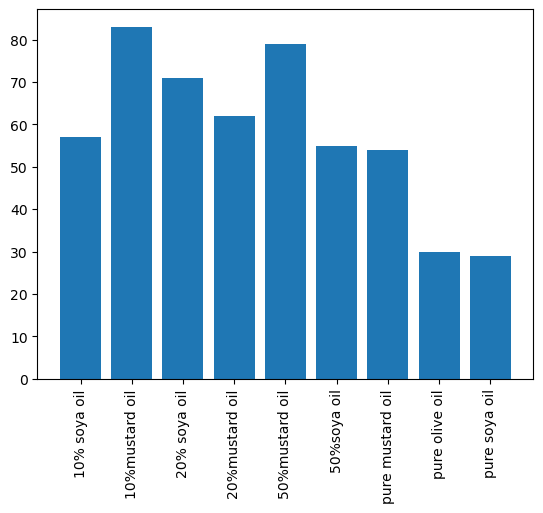

In [6]:
# Reading folders where each folder corresponds to each sample
dataset = 'C:/Users/HPCL-08/Desktop/old data/dataset/'
folders = os.listdir(dataset)
folders.sort()
# Count no.of images w.r.t each sample
img_count = {}
for folder in folders:
    cnt = len(os.listdir(dataset+folder+os.sep))
    img_count[folder] = cnt
# Plotting barplots of no.of leaf images w.r.t each sample
plt.bar(img_count.keys(), img_count.values())
plt.xticks(rotation='vertical')
plt.show()

In [7]:
path = 'C:/Users/HPCL-08/Desktop/old data/'
dataset = 'C:/Users/HPCL-08/Desktop/old data/dataset/'
folders = os.listdir(dataset)
folders.sort()
# Storing image data in csv file
img_names = []
img_array = []
labels = []
for folder in folders:
    imgs = os.listdir(dataset+folder+os.sep)
    imgs.sort()
    for img in imgs:
        im = cv2.imread(dataset+folder+os.sep+img)
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_size = cv2.resize(im_rgb, (144, 144), interpolation=cv2.INTER_AREA)
        img_names.append(img)
        img_array.append(im_size)
        labels.append(folder)
df = pd.DataFrame({'Image ID': img_names, 'Class': labels})
df.to_csv(path+'New folder/sample.csv', index=False)
# Saving image data in numpy array format
X = np.asarray(img_array)
np.save(path+'New folder/imgs_original', X)

In [8]:
data = pd.read_csv(path+'New folder/sample.csv')
data.head()

,Image ID,Class
0,IMG_20221020_114348.jpg,10% soya oil
1,IMG_20221020_114351.jpg,10% soya oil
2,IMG_20221020_114352.jpg,10% soya oil
3,IMG_20221020_114353.jpg,10% soya oil
4,IMG_20221020_114354.jpg,10% soya oil


In [9]:
# Mapping original class labels to integer values

labels = {}
val_cnt = 0
for folder in folders:
    labels[folder] = val_cnt
    val_cnt = val_cnt+1
X = np.load(path+'New folder/imgs_original.npy')
y = data['Class'].map(labels).values
data['Image Array'] = X.tolist()
data['Labels'] = y
data.head()

,Image ID,Class,Image Array,Labels
0,IMG_20221020_114348.jpg,10% soya oil,"[[[211, 211, 202], [219, 219, 216], [220, 219,...",0
1,IMG_20221020_114351.jpg,10% soya oil,"[[[216, 216, 218], [217, 217, 219], [218, 218,...",0
2,IMG_20221020_114352.jpg,10% soya oil,"[[[218, 216, 217], [217, 216, 217], [217, 216,...",0
3,IMG_20221020_114353.jpg,10% soya oil,"[[[212, 211, 207], [218, 217, 218], [218, 217,...",0
4,IMG_20221020_114354.jpg,10% soya oil,"[[[213, 214, 211], [217, 217, 219], [217, 217,...",0


In [10]:
data.to_csv('C:/Users/HPCL-08/Desktop/final data/New folder/image_new.csv', index=False)

In [32]:
X = data.drop(['Image ID', 'Class', 'Labels'], axis=1)
y = data['Labels']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
imbalance_train = X_tr.copy()
imbalance_train['Labels'] = y_tr
imbalance_train['Labels'].value_counts()

1    62
4    59
2    53
3    47
0    43
5    41
6    40
7    23
8    22
Name: Labels, dtype: int64

In [33]:
# Reference: upsampling in python-https://elitedatascience.com/imbalanced-classes
majority_class = imbalance_train[imbalance_train.Labels == 1]
# Upsampling for imbalance dataset in python
upsampled_classes = [majority_class]
minority_labels = [0,2,3,4,5,6,7,8]
for i in minority_labels:
    minority_class = imbalance_train[imbalance_train.Labels == i]
    minority_upsampled = resample(minority_class, replace = True,     n_samples = majority_class.shape[0],random_state = 0)
    upsampled_classes.append(minority_upsampled)
train_upsampled = pd.concat(upsampled_classes)
train_shuffled = train_upsampled.sample(frac=1, random_state=0)
X_tr1 = train_shuffled['Image Array'].values
y_tr1 = train_shuffled['Labels'].values
y_train = keras.utils.to_categorical(y_tr1, num_classes=9)
y_test = keras.utils.to_categorical(y_te, num_classes=9)
train_X = X_tr1.tolist()
X_train = np.asarray(train_X)
X_te1 = X_te['Image Array'].values
test_X = X_te1.tolist()
X_test = np.asarray(test_X)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(558, 144, 144, 3)
(130, 144, 144, 3)
(558, 9)
(130, 9)


In [35]:
#sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to 2d array
nsamples, nx, ny, nrgb = X_train.shape
x_train2 = X_train.reshape((nsamples,nx*ny*nrgb))

In [36]:
print(x_train2.shape)

(558, 62208)


In [37]:
#so,eventually,model.predict() should also be a 2d input
nsamples, nx, ny, nrgb = X_test.shape
x_test2 = X_test.reshape((nsamples,nx*ny*nrgb))

In [38]:
print(x_test2.shape)

(130, 62208)


In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
knn=KNeighborsClassifier(n_neighbors=5)

In [41]:
knn.fit(x_train2,y_train)

KNeighborsClassifier()

In [42]:
y_pred_knn=knn.predict(x_test2)
y_pred_knn

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [43]:
accuracy_score(y_pred_knn,y_test)

0.8384615384615385

In [44]:
from sklearn.metrics import classification_report
report= classification_report(y_test,y_pred_knn)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        14
           1       0.90      0.86      0.88        21
           2       0.82      0.78      0.80        18
           3       0.92      0.73      0.81        15
           4       0.90      0.90      0.90        20
           5       0.87      0.93      0.90        14
           6       0.91      0.71      0.80        14
           7       0.70      1.00      0.82         7
           8       0.86      0.86      0.86         7

   micro avg       0.85      0.84      0.84       130
   macro avg       0.85      0.85      0.84       130
weighted avg       0.86      0.84      0.84       130
 samples avg       0.84      0.84      0.84       130



In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
model=RandomForestClassifier()

In [54]:
model.fit(x_train2,y_train)

RandomForestClassifier()

In [55]:
y_pred=model.predict(x_test2)
y_pred

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [56]:
accuracy_score(y_pred,y_test)

0.9076923076923077

In [57]:
from sklearn.tree import DecisionTreeClassifier
#and then instantiating it to create a DecisionTreeClassifier model:

dtc=DecisionTreeClassifier()
#inally, train it:

dtc.fit(x_train2,y_train)
#Now, predict for the test set using the fitted decision tree model:

y_pred_dtc=dtc.predict(x_test2)
y_pred_dtc

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [58]:
accuracy_score(y_pred_dtc,y_test)

0.7692307692307693

In [59]:
accuracy_score(y_pred_dtc,y_test)
print(classification_report(y_pred_dtc,y_test))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.81      0.94      0.87        18
           2       0.61      0.79      0.69        14
           3       0.87      0.76      0.81        17
           4       0.90      0.82      0.86        22
           5       0.64      0.69      0.67        13
           6       0.79      0.73      0.76        15
           7       0.86      0.75      0.80         8
           8       0.71      0.62      0.67         8

   micro avg       0.77      0.77      0.77       130
   macro avg       0.77      0.75      0.76       130
weighted avg       0.78      0.77      0.77       130
 samples avg       0.77      0.77      0.77       130

